<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/stock/Momentum_Abs_Cross_Investing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install yfinance==0.2.43 --q

In [38]:

import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

# Step 1: Define the list of Nifty 50 stock symbols with Yahoo Finance tickers
nifty50_symbols = ['ADANIPORTS.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJAJFINSV.NS',
                   'BAJFINANCE.NS', 'BHARTIARTL.NS', 'BPCL.NS', 'BRITANNIA.NS', 'CIPLA.NS',
                   'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'GRASIM.NS',
                   'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HEROMOTOCO.NS',
                   'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS', 'INFY.NS',
                   'IOC.NS', 'ITC.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LT.NS',
                   'M&M.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'NTPC.NS', 'ONGC.NS',
                   'POWERGRID.NS', 'RELIANCE.NS', 'SBILIFE.NS', 'SBIN.NS', 'SHREECEM.NS',
                   'SUNPHARMA.NS', 'TATACONSUM.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TCS.NS',
                   'TECHM.NS', 'TITAN.NS', 'ULTRACEMCO.NS', 'UPL.NS', 'WIPRO.NS']

# Step 2: Download historical price data
end_date = '2023-12-31'
start_date = '2020-01-01'  # Approx 2 years

data = yf.download(nifty50_symbols, start=start_date, end=end_date)
adj_close = data['Adj Close']

# Step 3: Download Nifty 50 index data
nifty_index_symbol = '^NSEI'
nifty_data = yf.download(nifty_index_symbol, start=start_date, end=end_date)
nifty_adj_close = nifty_data['Adj Close']

# Step 4: Calculate daily returns
stock_returns = adj_close.pct_change().dropna()
nifty_returns = nifty_adj_close.pct_change().dropna()

# Step 5: Calculate moving averages for absolute momentum
short_window = 63  # 3 months
long_window = 126  # 6 months

short_ma = adj_close.rolling(window=short_window).mean()
long_ma = adj_close.rolling(window=long_window).mean()

# Determine absolute momentum
absolute_momentum = short_ma > long_ma

# Step 6: Calculate rolling beta
def calculate_rolling_beta(stock_returns, market_returns, window):
    covariance = stock_returns.rolling(window=window).cov(market_returns)
    variance = market_returns.rolling(window=window).var()
    beta = covariance / variance
    return beta

window = 252  # 1 year
beta = pd.DataFrame(index=stock_returns.index, columns=stock_returns.columns)

for stock in stock_returns.columns:
    beta[stock] = calculate_rolling_beta(stock_returns[stock], nifty_returns, window)

# Step 7: Calculate cumulative returns over the past 3 months
lookback_period = 63  # 3 months
cum_returns = stock_returns.rolling(window=lookback_period).apply(lambda x: (x + 1).prod() - 1)

# Step 8: Calculate beta-adjusted returns
beta = beta.replace(0, np.nan)
beta_adjusted_returns = cum_returns.div(beta)

# Step 9: Initialize positions DataFrame
strategy_dates = cum_returns.index.intersection(beta.index).intersection(absolute_momentum.index)
positions = pd.DataFrame(index=strategy_dates, columns=stock_returns.columns).fillna(0)

# Step 10: Portfolio Construction
N = 5  # Number of stocks to long and short

for date in strategy_dates:
    # Get stocks with positive absolute momentum
    abs_mom_stocks = absolute_momentum.loc[date]
    positive_momentum_stocks = abs_mom_stocks[abs_mom_stocks == True].index.tolist()

    # Get beta-adjusted returns for these stocks
    beta_adj_ret = beta_adjusted_returns.loc[date, positive_momentum_stocks]

    # Drop NaN values
    beta_adj_ret = beta_adj_ret.dropna()

    # If there are less than N stocks, skip this date
    if len(beta_adj_ret) < N:
        continue

    # Rank the stocks
    ranked_stocks = beta_adj_ret.sort_values(ascending=False)

    # Select top N stocks to long
    long_stocks = ranked_stocks.iloc[:N].index.tolist()



    # Set positions
    positions.loc[date, long_stocks] = 1  # Equally weighted longs

# Get the latest date where positions are available
latest_date = positions.dropna(how='all').index[-1]

# Get the positions on the latest date
latest_positions = positions.loc[latest_date]
# Get the stocks to go long
latest_long_stocks = latest_positions[latest_positions > 0].index.tolist()

print(f"\nLatest Date for Positioning: {latest_date.strftime('%Y-%m-%d')}")
print("List of 5 Stocks to Go Long:")
for stock in latest_long_stocks:
    print(f"- {stock.replace('.NS', '')}")


[*********************100%***********************]  49 of 49 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-38-ae86b0d0d3fe>:68: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  positions = pd.DataFrame(index=strategy_dates, columns=stock_returns.columns).fillna(0)



Latest Date for Positioning: 2023-12-29
List of 5 Stocks to Go Long:
- BAJAJ-AUTO
- BPCL
- HEROMOTOCO
- IOC
- POWERGRID


In [39]:
print(f"\nLatest Date for Positioning: {latest_date.strftime('%Y-%m-%d')}")
print("List of 5 Stocks to Go Long:")
for stock in latest_long_stocks:
    print(f"- {stock.replace('.NS', '')}")



Latest Date for Positioning: 2023-12-29
List of 5 Stocks to Go Long:
- BAJAJ-AUTO
- BPCL
- HEROMOTOCO
- IOC
- POWERGRID


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


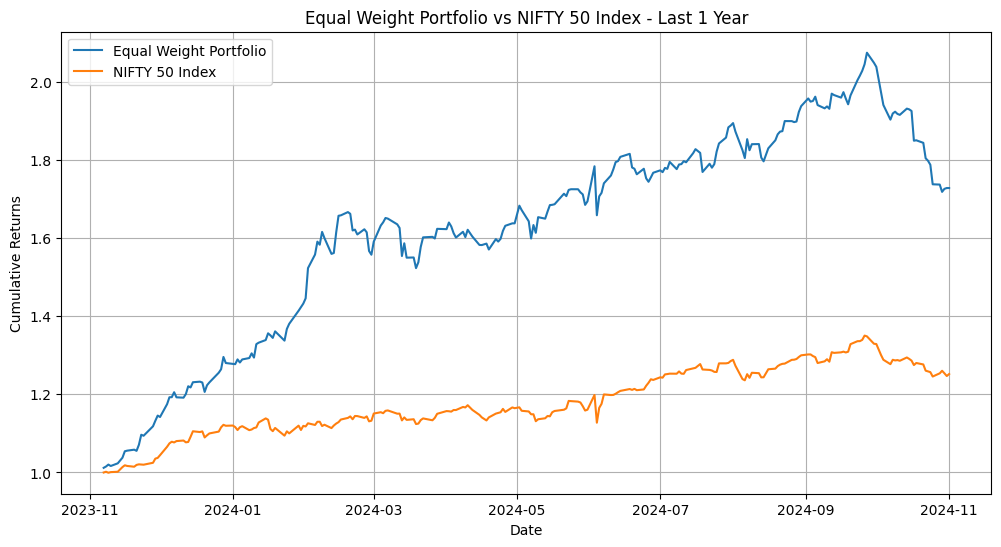

In [40]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# List of stock tickers
tickers = latest_long_stocks
index_ticker = '^NSEI'  # NIFTY 50 index ticker on Yahoo Finance

# Define the date range
end_date =datetime.today()
start_date = end_date - timedelta(days=365)

# Download stock data
stock_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Download index data
index_data = yf.download(index_ticker, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns for stocks
stock_returns = stock_data.pct_change().dropna()

# Calculate daily returns for the index
index_returns = index_data.pct_change().dropna()

# Assign equal weights
weights = [1/len(tickers)] * len(tickers)

# Calculate the portfolio returns
portfolio_returns = stock_returns.dot(weights)

# Calculate cumulative returns
portfolio_cumulative = (1 + portfolio_returns).cumprod()
index_cumulative = (1 + index_returns).cumprod()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cumulative.index, portfolio_cumulative, label='Equal Weight Portfolio')
plt.plot(index_cumulative.index, index_cumulative, label='NIFTY 50 Index')
plt.title('Equal Weight Portfolio vs NIFTY 50 Index - Last 1 Year')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()
